In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np
import math, random
import matplotlib.pyplot as plt

import copy
import timeit

## In this notebook I try to overfit an RNN/LSTM/GRU to a sin wave. Once trained our RNN should be able to produce a whole sin wave from just one initial input sequence.

In [2]:
# Hyper parameters

SEQUENCE_LENGTH = 50  # How many timesteps we will use in our RNN.
INPUT_SIZE = 1  # This is the feature size, in our case it will be just 1. For other tasks (like NLP) it would be much bigger   
LR = 0.1  # Learning rate
BATCH_SIZE = 64  
HIDDEN_SIZE = 7  # Hidden size dimension ( also will be the output size of our RNN unit )
NUM_LAYERS = 1  # How many layers of RNN to stack together. 
RNN_TYPE = 'LSTM' # Choose from 'RNN' 'LSTM' 'GRU'
NUM_EPOCHS = 10

## Create our data and set it into the right format for training. From SEQUENCE_LENGTH number of sequential points in our sin wave we try to predict what the next value should be.

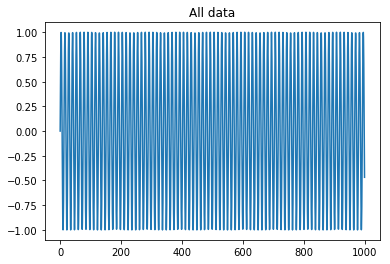

1950 total sequence samples, 1560 used for training


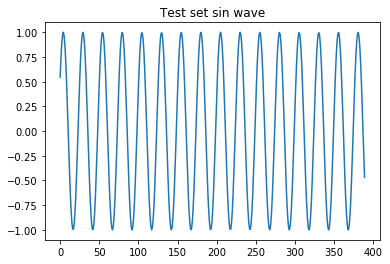

In [3]:
# Prepare our dataset for inputting into our model
# Data dimensions should be in this order: [batch, sequence, feature] where feature is INPUT_SIZE

time_steps = np.linspace(0, 1000, 2000, dtype=np.float32)   
sin_time_steps = np.sin(time_steps*0.5)# * time_steps #* np.cos(time_steps*0.1)


plt.plot(time_steps[:],sin_time_steps[:])
plt.title("All data")
plt.show()
# We need to get an extra value to be the value we aim to predict.
sequence_length = SEQUENCE_LENGTH + 1  

# Take sequence_length of our sin wave and put that as a row in sequence_data, this will be one input into our RNN.
# Move one time step and repeat till we reach the end of our sampled sin wave.
sequence_data = []
for i in range(len(sin_time_steps) - sequence_length+1):
    sequence_data.append(sin_time_steps[i: i + sequence_length])
sequence_data = np.array(sequence_data)

# Split for train/test and shuffle train set.
num_samples = sequence_data.shape[0]
num_train = int(0.80 * num_samples)

train_set = sequence_data[:num_train,:]
test_set = sequence_data[num_train:,:]

np.random.shuffle(train_set)
print('{} total sequence samples, {} used for training'.format(num_samples, num_train))

# Take off the last element or each row and this will be our target value to predict. 
# We now have SEQUENCE LENGTH elements in each row.
x_train = train_set[:, :-1][:,:,np.newaxis]
y_train = train_set[:, -1][:,np.newaxis]
x_test = test_set[:, :-1][:,:,np.newaxis]
y_test = test_set[:, -1][:,np.newaxis]

plt.plot(y_test[:])
plt.title("Test set sin wave")
plt.show()

In [4]:
# Define our RNN model as a new class inheriting from nn.Module. Our model will be one multilayer RNN followed by a linear 
# layer to produce our final output.

class SimpleRNN(nn.Module):
    
    # Constructor will initialise an RNN node and a linear layer.
    def __init__(self):
        super(SimpleRNN, self).__init__()
        
        # Initialise the correct RNN layer depending on what we chose.
        if RNN_TYPE == 'RNN':
            self.rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, dropout=0.0, num_layers=NUM_LAYERS, batch_first=True)  
        elif RNN_TYPE == 'LSTM':
            self.rnn = nn.LSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE,dropout=0.0, num_layers=NUM_LAYERS, batch_first=True)  
        elif RNN_TYPE == 'GRU':
            self.rnn = nn.GRU(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, dropout=0.0, num_layers=NUM_LAYERS, batch_first=True) 
        
        self.out = nn.Linear(HIDDEN_SIZE, 1)
    
    # Define our forward pass, for input we take some input sequence and an initial hidden state.
    def forward(self, x, h_state):

        r_out, h_state = self.rnn(x, h_state)
        final_y = self.out(r_out[:,-1,:])
        
        return final_y, h_state

# Check it creates our model structure okay.
rnn = SimpleRNN()
print(rnn)

SimpleRNN (
  (rnn): LSTM(1, 7, batch_first=True)
  (out): Linear (7 -> 1)
)


In [5]:
# If gpu is available lets use it.
if torch.cuda.is_available:
    dtype = torch.cuda.FloatTensor
    rnn = copy.deepcopy(rnn).type(dtype)
else: 
    dtype = torch.FloatTensor

In [6]:
# Initialise the optimizer
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.MSELoss()

In [7]:
# Convert the hidden, cell state, train data & labels to gpu/cpu type 
h_state = Variable(torch.zeros(NUM_LAYERS*1,BATCH_SIZE,HIDDEN_SIZE).type(dtype))
c_state = Variable(torch.zeros(NUM_LAYERS*1,BATCH_SIZE,HIDDEN_SIZE).type(dtype))
x_batch_all = Variable(torch.from_numpy(x_train).type(dtype))
labels_all = Variable(torch.from_numpy(y_train).type(dtype))

loss:  [ 0.00508564]
loss:  [ 0.00220064]
loss:  [ 0.0004258]
loss:  [  4.55340560e-05]
loss:  [  1.08111599e-05]
loss:  [  5.03859792e-06]
loss:  [  4.42551027e-06]
loss:  [  4.21120876e-06]
loss:  [  3.14285967e-06]
loss:  [  2.70137616e-06]


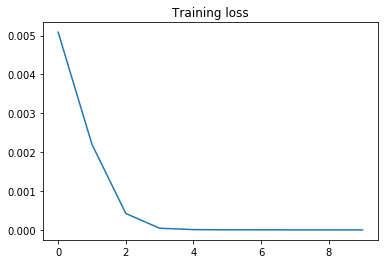

In [8]:
# Train loop.
loss_all = []
for epoch in range(NUM_EPOCHS):
    for i in range(int(len(x_train)/BATCH_SIZE)):
                      
        # Get a batch of data and labels.
        x_batch = x_batch_all[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE,:,:]
        labels = labels_all[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]
        
        # Zero our gradients
        optimizer.zero_grad()
        
        # Run our chosen rnn model.
        if RNN_TYPE in {'RNN','GRU'}:
            output, _ = rnn(x_batch, (h_state))  
        elif RNN_TYPE in {'LSTM'}:
            output, _ = rnn(x_batch, (h_state,c_state))  
        
        # Calculate loss.
        loss = loss_func(output, labels)
        
        # Backprop the loss.
        loss.backward()
        
        # Perform an update step
        optimizer.step()
    
    loss_all.append(loss.cpu().data.numpy())    
    print('loss: ' , loss.cpu().data.numpy())
    
plt.plot(loss_all)
plt.title('Training loss')
plt.show()                     

## Now we test if our model has learnt how to produce a sin wave. We feed it the first SEQUENCE_LENGTH points in the wave and let it generate the next point. We then pop off the first point and add on our generated point,  then from these we generate the next. We keep 'sliding' our window to generate our whole sequence.  

In [9]:
# Test our trained model.
h_state = Variable(torch.zeros(NUM_LAYERS*1,1,HIDDEN_SIZE).type(dtype))
c_state = Variable(torch.zeros(NUM_LAYERS*1,1,HIDDEN_SIZE).type(dtype))
initial_input =  Variable(torch.from_numpy(y_test[0:SEQUENCE_LENGTH,:]).type(dtype))
initial_input.data.unsqueeze_(0)  # Need to add our batch dimension back in as our batch size for test is only 1.

final_outputs = []

for i in range(int(len(y_test/2)-SEQUENCE_LENGTH)):
   
    # Run our chosen rnn model.
    if RNN_TYPE in {'RNN','GRU'}:
        output, _ = rnn(initial_input, (h_state))  
    elif RNN_TYPE in {'LSTM'}:
        output, _ = rnn(initial_input, (h_state,c_state))  
        
    final_outputs.append(output.cpu().data.numpy())
    
    # Pop off the first element of the sequence and then add on our latest generated point.
    initial_input.data[:,0:SEQUENCE_LENGTH-1,:] = initial_input.data[:,1:SEQUENCE_LENGTH,:]
    initial_input.data[:,SEQUENCE_LENGTH-1,:] = output.data
    

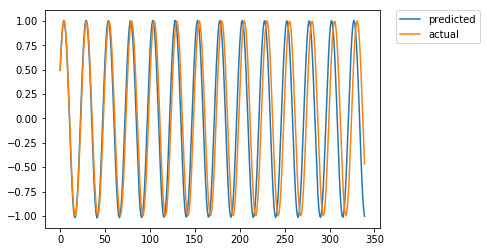

In [10]:
final_pred = np.array(final_outputs).squeeze()
plt.plot(final_pred, label = 'predicted')
plt.plot(y_test[SEQUENCE_LENGTH:], label = 'actual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## We can see that as we go further ahead in time the errors of earlier predictions start to add up and the amplitude of our sequence goes out of sync.